# House Price Predictor
#### A Kaggle Competition

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# Import Data and deal with missing values

raw_train_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')

raw_data = pd.concat([raw_train_data, raw_test_data]).reset_index(drop=True)

# raw_data.info()


# train: ID 1 - 1460, test: ID 1461 - 2919

# Drop all the columns with significant amounts of missing data, i.e. Alley - 198 non Nan, PoolQC - 10, Fence - 571
## MiscFeature - 105, I've also dropped Utilities as these are all identical apart from 3 entries

data = raw_data.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Utilities'], axis=1)


data.MSZoning = raw_data.apply(lambda row: row.MSZoning if type(row.MSZoning) == 'String' else 
                               raw_data[raw_data.MSSubClass == row.MSSubClass].MSZoning.mode(), axis=1)

data.LotFrontage = raw_data.LotFrontage.apply(lambda x: 0 if pd.isna(x) else x)

for col in ['Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Electrical', 'KitchenQual', 'Functional', 
            'SaleType']:
    data[col] = raw_data[col].apply(lambda x: raw_data[col].mode()[0] if pd.isna(x) else x)


data.at[2217, 'BsmtQual'] = raw_data.BsmtQual.mode()
data.at[2218, 'BsmtQual'] = raw_data.BsmtQual.mode()

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = raw_data[col].apply(lambda x: 'None' if pd.isna(x) else x)


for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars',
            'GarageArea']:
    data[col] = raw_data[col].apply(lambda x: 0 if pd.isna(x) else x)

    
for col in ['GarageYrBlt']:
    data[col] = raw_data[col].apply(lambda x: raw_data[col].mean() if pd.isna(x) else x)

  
# data.info()
 

In [3]:
def encode(dataframe, column):
    dummy = pd.get_dummies(dataframe[column], prefix=column)
    df = dataframe.join(dummy)
    df.drop(column, axis=1, inplace=True)
    return df

In [4]:
# Now to transform/make the features usable. As there are already so many features in the data I want to avoid 
## simple binary encoding where possible - instead for the ordinal variables I'll assign a number value


for col in ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st', 
            'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical',
            'Functional', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']:
    
    data = encode(data, col)


for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual',
            'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']:
    
    if col == 'BsmtExposure':
        rating_dict = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'None':0}
    else:
        rating_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0, 'Fin':3, 'RFn':2, 'Unf':1, 'Y':1, 'N':0}

    data[col] = data[col].map(rating_dict)
   
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 251 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(12), int64(36), uint8(203)
memory usage: 1.6 MB
None


In [5]:
# Split data and standardise

X = data.drop('SalePrice', axis=1).iloc[:1460,:]
y = data.SalePrice.iloc[:1460]

X_test = data.drop('SalePrice', axis=1).iloc[1460:,:]
y_test = data.SalePrice.iloc[1460:]

# print(X_test.head())

# Standardise all data

# print(data.columns)

ct = ColumnTransformer([('scale',StandardScaler(),['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt'
                                                   , 'YearRemodAdd','MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual'
                                                   , 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 
                                                   'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
                                                   'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                                                   'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
                                                   'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                                                   'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                                                   'MoSold', 'YrSold'])], remainder='passthrough')

X = pd.DataFrame(ct.fit_transform(X), columns=X_test.columns)

X_test = pd.DataFrame(ct.transform(X_test), columns=X.columns)
X_test.index = y_test.index

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 10, train_size = 0.8)


In [6]:
# Model Selection
pipeline = Pipeline([('clf', Ridge())])

param1 = {'clf': [Ridge(max_iter = 20000)], 'clf__alpha': np.logspace(-1,3, num=20)}
param2 = {'clf': [Lasso(max_iter = 20000)], 'clf__alpha': np.logspace(-1,3, num=20)}


param_grid = [param1, param2]

grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = 'neg_mean_absolute_percentage_error',
                    cv = 10, return_train_score = True, verbose = 1)

grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_score_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Pipeline(steps=[('clf', Lasso(alpha=143.8449888287663, max_iter=20000))])
-0.10839734632590622


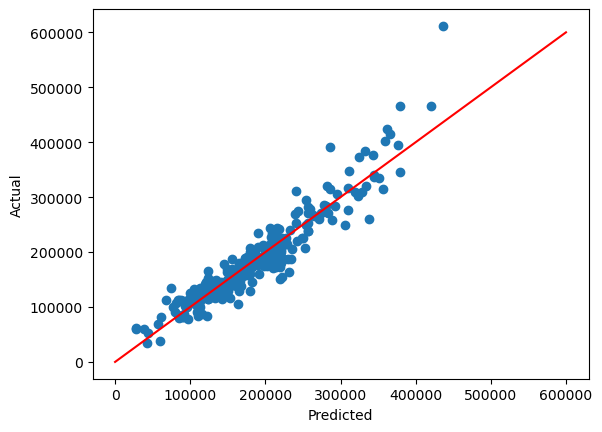

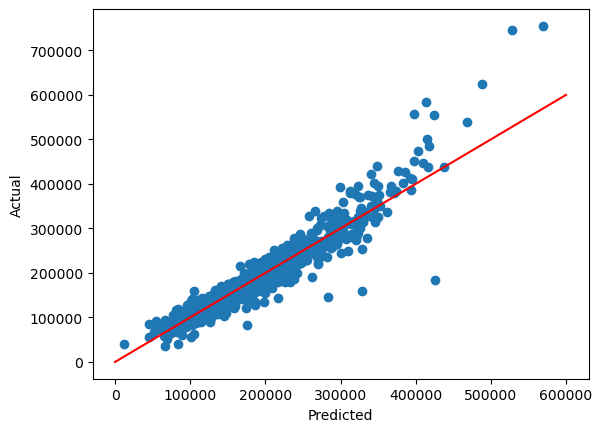

In [7]:
# Visualise Results
model = grid.best_estimator_

plt.figure()

y_val_pred = model.predict(X_val)

plt.scatter(y_val_pred, y_val)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.plot([0,600000], [0, 600000],'r')

plt.figure()

y_train_pred = model.predict(X_train)

plt.scatter(y_train_pred, y_train)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.plot([0,600000], [0, 600000],'r')

plt.show()


In [8]:
# Predict outcomes

predictions = pd.DataFrame()

predictions['Id'] = X_test.index + 1
predictions['SalePrice'] = model.predict(X_test).astype('int')

print(predictions)

predictions.to_csv('predictions.csv', index=False)


        Id  SalePrice
0     1461     112015
1     1462     162045
2     1463     172094
3     1464     185509
4     1465     213212
...    ...        ...
1454  2915      83582
1455  2916      77275
1456  2917     165944
1457  2918     117056
1458  2919     237957

[1459 rows x 2 columns]
